# Draft - start with some linear regression model to warm up...

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [1]:
features = ['B10',
 'F12',
 'F13',
 'F14',
 'F15',
 'G1',
 'G2',
 'G3',
 'G4',
 'G5',
 'G6',
 'G6_TOTAL', # derived score
 'G21', # clinical diagnosis
 'minimental30', #red -> Mini mental for illiteral, max=23
 'MMSE28', # red -> capable of performing MMSE item 28 (read the sentence)
 'MMSE29', # red -> capable of performing MMSE item 29 (knew what a sentence is and attempted to write)
 'll1cor1', # red -> List learning trial 1 correct 1st exam 
 'll2cor1', # red -> List Learning trial 2 correct 1st exam 
 'll2sim1', # red -> List learning 2 similars
 'll3cor1', # red -> List learning 3 correct 1st exam 
 'll3sim1', # red -> List learning 3 similars
 'll4cor1', # red -> List Learning trial 4 correct 1st exam
 'll4sim1', # red -> List learning trial 4 similars
 'll5cor1', # red -> List learning trial 5 correct 1st exam
 'll5sim1', # red -> List learning trial 5 similars
 'Sum1_5correct1st', # red -> List learning-Total sum of corrects (trials 1 to 5) 1st
 'llkampilimathisis1', # red -> List learning kampili mathisis 1st (trial5correct-trial1cor) 
 'll6cor1', # red -> List learning trial 6 correct 1st
 'll6sim1', # red -> List learning trial 6 similars
 'll7cor1', # red -> List learning trial 7 correct 1st
 'll7sim1', # red -> List learning trial 7 similars
 'll8cor1', # red -> List learning trial 8 correct 1st
 'll9cor1', # red -> List learning trial 9 correct 1st
 'll9sim1', # red -> List learning trial 9 similars
 'll10cor1',# red -> List learning trial 10 correct 1st
 'llta1', # red -> List learning tritis asxeta
 'Recognrecalldiscr', # red ->  Recognrecalldiscr
 'Encodingdefindex1', # red -> List learning encoding deficit index 1 (number of items that are recalled less than two or fewer trials )
 'figurecopy', # red -> MCG complex figure test-copy condition
 'figureimmediate', # red -> MCG complex figure test-immediate recall condition
 'figuredelayed', # red -> MCG complex figure test-delayed recall condition
 'ST_D_2_immedpercentile1st', # red -> MCG complex figure test-% on immediate recall (% of copy score)
 'jlo1stdiades', # red -> judgement of line orientation 1st exam (max=10, ana diades)
 'jloolesmax20', # red -> judgement of line orientation 1st exam (max=20, xorista)
 'TMTA_tmtAtime1', # red -> Trail making test part A time SEC 1st
 'TMTA_tmtAerr1', # red -> Trail making test part A errors 1st
 'vfsem1stobj', # red -> Verbal fluency semantic 1st objects
 'vfsemobjswich', # red -> Verbal fluency semantic 1st objects swiches
 'vfphon1stalphobj', # red -> Verbal fluency phonological 1st alpha
 'vfphaswi', # red -> Verbal fluency phonological 1st alpha switches
 'naming1st', # red -> naming 1st exam
 'comphr1st', # red -> comprehension 1st exam
 'repetition1st', # red -> repetition 1st exam
 'sentrepeatcorrect1', # red -> number of correct sentences (max=14)
 'sentrepeattargetr', # red -> number of sentences in which replaced the target words
 'grafseqcorrect1', # red -> correct responses (max=6)
 'frontaltestA1st', # red -> correct responses Go/No-Go A (max=20) 1st exam, same way
 'frontaltestB1s', # red -> frontaltestB1s
 'EduC',
 'AgeC']

In [2]:
import pandas as pd
df = pd.read_csv("OUTCOME_DIAGNOSIS_processed.csv", header=0)
df.dropna(subset=['ZCO'], inplace=True)

In [4]:
correlations

B10                          0.344203
F12                          0.365282
F13                          0.380012
F14                          0.358328
F15                          0.411934
G1                           0.480267
G2                           0.458763
G3                           0.465999
G4                           0.459123
G5                           0.442959
G6                           0.403125
G6_TOTAL                     0.491678
G21                          0.525794
minimental30                 0.727769
MMSE28                       0.449331
MMSE29                       0.514529
ll1cor1                      0.515762
ll2cor1                      0.582816
ll2sim1                      0.406088
ll3cor1                      0.638045
ll3sim1                      0.469902
ll4cor1                      0.644914
ll4sim1                      0.496416
ll5cor1                      0.674517
ll5sim1                      0.518142
Sum1_5correct1st             0.681903
llkampilimat

In [3]:
correlations = df[features].corrwith(df['ZCO']).abs()
super_correlated = correlations[correlations > 0.9]

print(f"Features with >0.9 correlation to ZCO:")
print(super_correlated.sort_values(ascending=False))

Features with >0.9 correlation to ZCO:
Series([], dtype: float64)


In [5]:
X = df[features]
Y = df["ZCO"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Training samples: 1293, Test samples: 324
Number of features: 60


In [9]:
discrete_cols = []
continuous_cols = []

for col in X_train.columns:
    # Check if column is likely discrete/categorical
    n_unique = X_train[col].nunique(dropna=True)
    
    # Rule: Few unique values OR integer dtype = discrete
    if (n_unique <= 10) or (X_train[col].dtype in ['int64', 'int32', 'int16', 'int8', 'bool']):
        discrete_cols.append(col)
    else:
        continuous_cols.append(col)

print(f"{len(discrete_cols)} discrete and {len(continuous_cols)} continuous features")

17 discrete and 43 continuous features


In [10]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import BayesianRidge

X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

if discrete_cols:
    print(f"Imputing discrete features ({len(discrete_cols)} columns)...")
    disc_imputer = SimpleImputer(strategy='most_frequent')
    
    # Fit on train, transform both
    X_train_discrete = disc_imputer.fit_transform(X_train[discrete_cols])
    X_test_discrete = disc_imputer.transform(X_test[discrete_cols])
    
    # Update DataFrames
    X_train_imputed[discrete_cols] = X_train_discrete
    X_test_imputed[discrete_cols] = X_test_discrete

if continuous_cols:
    print(f"Imputing continuous features ({len(continuous_cols)} columns) with IterativeImputer...")
    cont_imputer = IterativeImputer(
        estimator=BayesianRidge(),
        max_iter=10,
        random_state=42,
        initial_strategy='mean'
    )
    X_train_continuous = cont_imputer.fit_transform(X_train[continuous_cols])
    X_test_continuous = cont_imputer.transform(X_test[continuous_cols])
    
    X_train_imputed[continuous_cols] = X_train_continuous
    X_test_imputed[continuous_cols] = X_test_continuous

train_nan = X_train_imputed.isna().sum().sum()
test_nan = X_test_imputed.isna().sum().sum()

if train_nan == 0 and test_nan == 0:
    print("Imputation successful! No missing values remain.")
else:
    print(f"Warning: {train_nan} train and {test_nan} test NaN remain")

Imputing discrete features (17 columns)...
Imputing continuous features (43 columns) with IterativeImputer...
Imputation successful! No missing values remain.


/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:867: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

During cross-validation, provide alpha values in a range of 100 numbers from 0.00005 to 1.
The best alpha balances fitting signals vs ignoring noise, found via cross-validation.

In [12]:
from sklearn.linear_model import Lasso, LassoCV, LassoLarsIC
import numpy as np

lasso_cv = LassoCV(
    alphas=np.logspace(-5, 1, 100),
    cv=10,
    max_iter=10000,
    random_state=42,
    n_jobs=-1
)
sample_weight = np.where(y_train < -1, 100.0, 1.0)
lasso_cv.fit(X_train_scaled, y_train, sample_weight)

LassoCV(alphas=array([1.00000000e-05, 1.14975700e-05, 1.32194115e-05, 1.51991108e-05,
       1.74752840e-05, 2.00923300e-05, 2.31012970e-05, 2.65608778e-05,
       3.05385551e-05, 3.51119173e-05, 4.03701726e-05, 4.64158883e-05,
       5.33669923e-05, 6.13590727e-05, 7.05480231e-05, 8.11130831e-05,
       9.32603347e-05, 1.07226722e-04, 1.23284674e-04, 1.41747416e-04,
       1.62975083e-04, 1.87381742e-0...
       4.03701726e-01, 4.64158883e-01, 5.33669923e-01, 6.13590727e-01,
       7.05480231e-01, 8.11130831e-01, 9.32603347e-01, 1.07226722e+00,
       1.23284674e+00, 1.41747416e+00, 1.62975083e+00, 1.87381742e+00,
       2.15443469e+00, 2.47707636e+00, 2.84803587e+00, 3.27454916e+00,
       3.76493581e+00, 4.32876128e+00, 4.97702356e+00, 5.72236766e+00,
       6.57933225e+00, 7.56463328e+00, 8.69749003e+00, 1.00000000e+01]),
        cv=10, max_iter=10000, n_jobs=-1, random_state=42)

R-square provides a metric to define how much of the variance our model can explain towards met predictions. It's the difference between 100% and the variance that cannot be explained by the model.

In [13]:
print(f"Optimal alpha (λ): {lasso_cv.alpha_:.6f}")
print(f"Mean CV R²: {lasso_cv.mse_path_.mean(axis=1).max():.4f}")

Optimal alpha (λ): 0.016298
Mean CV R²: 0.6532


Insights on penalty scores... 
- With AIC, check whether features are worth in terms of raising R-squared. Meaning that if a feature doesn't add much value, that is adding to R-square significantly, then it'll be penalized.
- BIC follows a much stricter approach, which is implemented by penalizing on cost of complexity - suggesting higher alpha values, aggresively striving to minimize features further.

In [14]:
from sklearn.linear_model import LassoLarsIC

lasso_aic = LassoLarsIC(criterion='aic')
lasso_bic = LassoLarsIC(criterion='bic')

lasso_aic.fit(X_train_scaled, y_train)
lasso_bic.fit(X_train_scaled, y_train)

print(f"AIC optimal alpha: {lasso_aic.alpha_:.6f}")
print(f"BIC optimal alpha: {lasso_bic.alpha_:.6f}")

if lasso_aic.alpha_ < 0.003:
    print("AIC thinks you could be LESS regularized (keep more features)")
elif lasso_aic.alpha_ > 0.003:
    print("AIC thinks you should be MORE regularized (fewer features)")

AIC optimal alpha: 0.000953
BIC optimal alpha: 0.009323
AIC thinks you could be LESS regularized (keep more features)


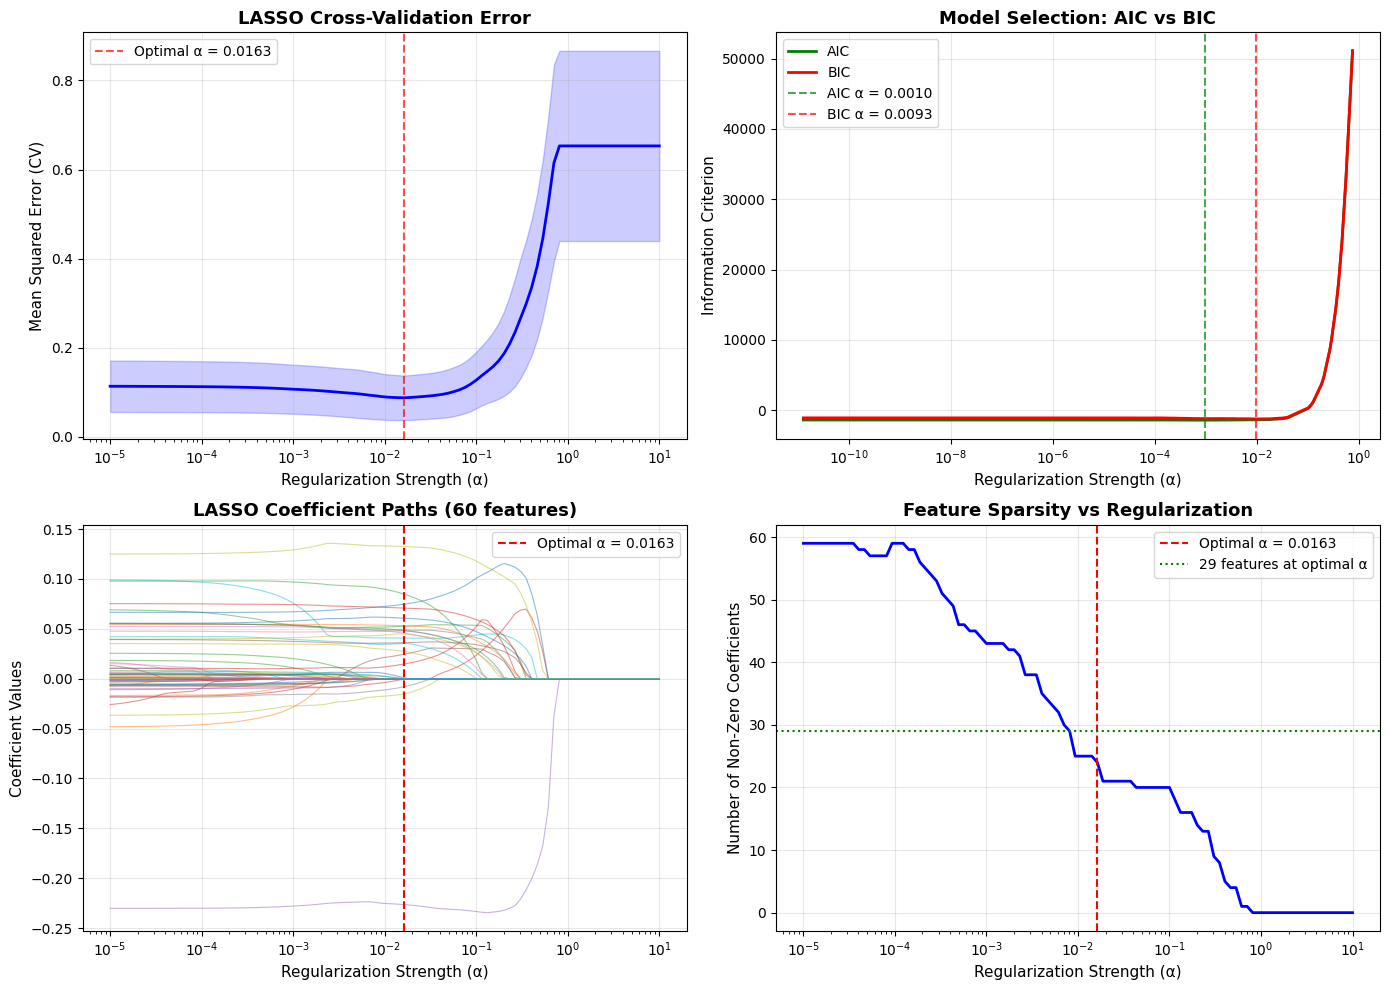

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].semilogx(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1), 'b-', linewidth=2)
axes[0,0].axvline(lasso_cv.alpha_, color='red', linestyle='--', alpha=0.7, 
                  label=f'Optimal α = {lasso_cv.alpha_:.4f}')
axes[0,0].fill_between(lasso_cv.alphas_,
                      lasso_cv.mse_path_.mean(axis=1) - lasso_cv.mse_path_.std(axis=1),
                      lasso_cv.mse_path_.mean(axis=1) + lasso_cv.mse_path_.std(axis=1),
                      alpha=0.2, color='blue')
axes[0,0].set_xlabel('Regularization Strength (α)', fontsize=11)
axes[0,0].set_ylabel('Mean Squared Error (CV)', fontsize=11)
axes[0,0].set_title('LASSO Cross-Validation Error', fontsize=13, fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(lasso_aic.alphas_, lasso_aic.criterion_, 'g-', linewidth=2, label='AIC')
axes[0,1].plot(lasso_bic.alphas_, lasso_bic.criterion_, 'r-', linewidth=2, label='BIC')
axes[0,1].axvline(lasso_aic.alpha_, color='green', linestyle='--', alpha=0.7, 
                  label=f'AIC α = {lasso_aic.alpha_:.4f}')
axes[0,1].axvline(lasso_bic.alpha_, color='red', linestyle='--', alpha=0.7, 
                  label=f'BIC α = {lasso_bic.alpha_:.4f}')
axes[0,1].set_xlabel('Regularization Strength (α)', fontsize=11)
axes[0,1].set_ylabel('Information Criterion', fontsize=11)
axes[0,1].set_title('Model Selection: AIC vs BIC', fontsize=13, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xscale('log')

from sklearn.linear_model import lasso_path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, 
                                          alphas=lasso_cv.alphas_, max_iter=10000)

for coef in coefs_lasso:
    axes[1,0].semilogx(alphas_lasso, coef, alpha=0.5, linewidth=0.8)
axes[1,0].axvline(lasso_cv.alpha_, color='red', linestyle='--', 
                  label=f'Optimal α = {lasso_cv.alpha_:.4f}')
axes[1,0].set_xlabel('Regularization Strength (α)', fontsize=11)
axes[1,0].set_ylabel('Coefficient Values', fontsize=11)
axes[1,0].set_title(f'LASSO Coefficient Paths ({len(features)} features)', 
                   fontsize=13, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

n_nonzero = [np.sum(coefs_lasso[:, i] != 0) for i in range(len(alphas_lasso))]
axes[1,1].semilogx(alphas_lasso, n_nonzero, 'b-', linewidth=2)
axes[1,1].axvline(lasso_cv.alpha_, color='red', linestyle='--', 
                  label=f'Optimal α = {lasso_cv.alpha_:.4f}')
axes[1,1].axhline(np.sum(lasso_cv.coef_ != 0), color='green', linestyle=':', 
                  label=f'{np.sum(lasso_cv.coef_ != 0)} features at optimal α')
axes[1,1].set_xlabel('Regularization Strength (α)', fontsize=11)
axes[1,1].set_ylabel('Number of Non-Zero Coefficients', fontsize=11)
axes[1,1].set_title('Feature Sparsity vs Regularization', fontsize=13, fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

final_lasso = lasso_cv
y_train_pred = final_lasso.predict(X_train_scaled)
y_test_pred = final_lasso.predict(X_test_scaled)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nSelected Model: LASSO (α = {final_lasso.alpha_:.6f})")
print(f"\nPERFORMANCE METRICS:")
print(f"   Training R²:     {train_r2:.4f}")
print(f"   Test R²:         {test_r2:.4f}")
print(f"   Training RMSE:   {train_rmse:.4f}")
print(f"   Test RMSE:       {test_rmse:.4f}")
print(f"   Training MAE:    {train_mae:.4f}")
print(f"   Test MAE:        {test_mae:.4f}")
print(f"\nOVERFITTING CHECK:")
print(f"   R² Gap (Train-Test): {train_r2 - test_r2:.4f}")
print(f"   RMSE Ratio (Test/Train): {test_rmse/train_rmse:.4f}")

cv_scores = cross_val_score(final_lasso, X_train_scaled, y_train, 
                           cv=5, scoring='r2')
print(f"\n🔄 CROSS-VALIDATION STABILITY:")
print(f"   Mean CV R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


Selected Model: LASSO (α = 0.016298)

PERFORMANCE METRICS:
   Training R²:     0.9356
   Test R²:         0.9033
   Training RMSE:   0.2257
   Test RMSE:       0.2842
   Training MAE:    0.1859
   Test MAE:        0.1968

OVERFITTING CHECK:
   R² Gap (Train-Test): 0.0323
   RMSE Ratio (Test/Train): 1.2594


/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.019e-02, tolerance: 7.348e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.434e-02, tolerance: 7.348e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not con


🔄 CROSS-VALIDATION STABILITY:
   Mean CV R²: 0.9715 (±0.0057)


/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.396e-02, tolerance: 7.622e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.830e-02, tolerance: 7.622e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not con

In [17]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': final_lasso.coef_,
    'Abs_Coefficient': np.abs(final_lasso.coef_),
    'Non_Zero': final_lasso.coef_ != 0
})

feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print(f"\nFeature Summary:")
print(f"   Total features: {len(features)}")
print(f"   Non-zero coefficients: {np.sum(final_lasso.coef_ != 0)}")
print(f"   Zero coefficients: {np.sum(final_lasso.coef_ == 0)}")
print(f"   Sparsity: {100*np.sum(final_lasso.coef_ == 0)/len(features):.1f}%")

print(f"\nTOP 15 MOST IMPORTANT FEATURES:")
pd.set_option('display.float_format', '{:.6f}'.format)
print(feature_importance.head(15).to_string(index=False))

zero_features = feature_importance[feature_importance['Coefficient'] == 0]
print(f"\n{len(zero_features)} FEATURES SHRUNK TO ZERO:")
if len(zero_features) > 0:
    print(zero_features['Feature'].tolist())
else:
    print("(All features have non-zero coefficients)")


Feature Summary:
   Total features: 60
   Non-zero coefficients: 29
   Zero coefficients: 31
   Sparsity: 51.7%

TOP 15 MOST IMPORTANT FEATURES:
           Feature  Coefficient  Abs_Coefficient  Non_Zero
    TMTA_tmtAtime1    -0.182836         0.182836      True
        figurecopy     0.153014         0.153014      True
         naming1st     0.101298         0.101298      True
sentrepeatcorrect1     0.073905         0.073905      True
           ll9cor1     0.067619         0.067619      True
          vfphaswi     0.065236         0.065236      True
         comphr1st     0.061299         0.061299      True
      jloolesmax20     0.054140         0.054140      True
     figuredelayed     0.048464         0.048464      True
    frontaltestB1s     0.046889         0.046889      True
   frontaltestA1st     0.045633         0.045633      True
       vfsem1stobj     0.045226         0.045226      True
      jlo1stdiades     0.035121         0.035121      True
                G4    -0.030

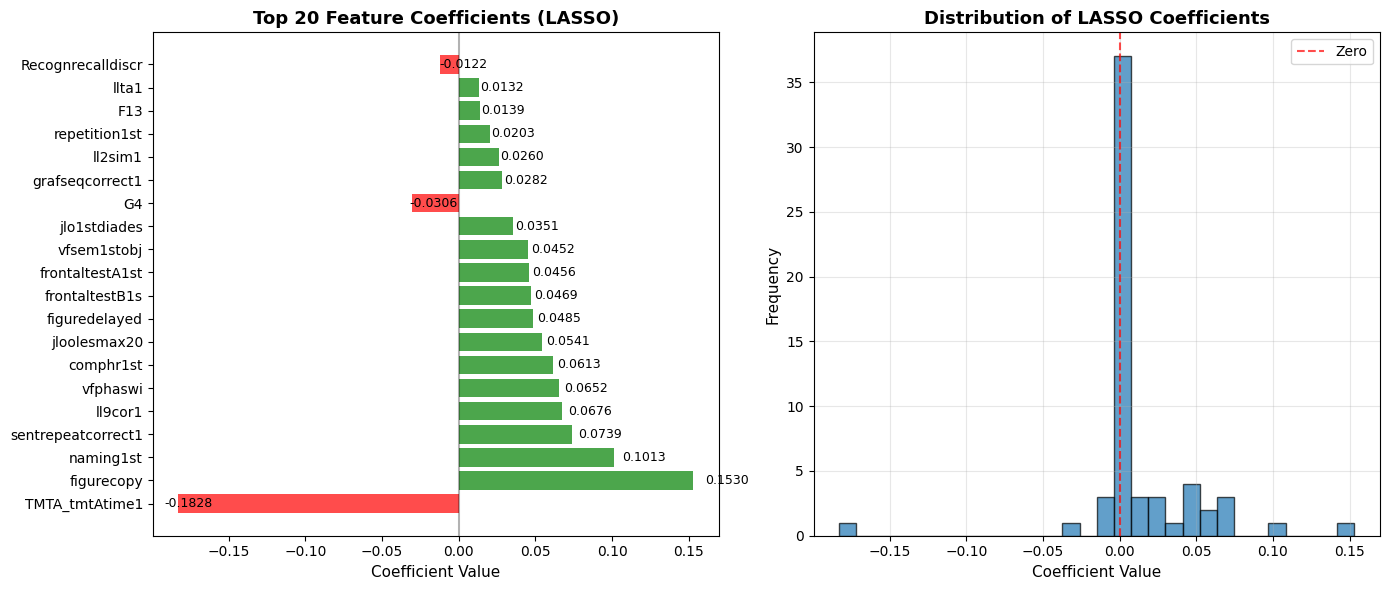

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
top_n = min(20, len(feature_importance))
top_features = feature_importance.head(top_n)

colors = ['red' if coef < 0 else 'green' for coef in top_features['Coefficient']]
axes[0].barh(range(top_n), top_features['Coefficient'], color=colors, alpha=0.7)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_features['Feature'])
axes[0].set_xlabel('Coefficient Value', fontsize=11)
axes[0].set_title(f'Top {top_n} Feature Coefficients (LASSO)', fontsize=13, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

for i, (coef, abs_coef) in enumerate(zip(top_features['Coefficient'], top_features['Abs_Coefficient'])):
    axes[0].text(abs_coef * 1.05 if coef >= 0 else -abs_coef * 1.05, 
                i, f'{coef:.4f}', va='center', fontsize=9)

axes[1].hist(feature_importance['Coefficient'], bins=30, alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero')
axes[1].set_xlabel('Coefficient Value', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution of LASSO Coefficients', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

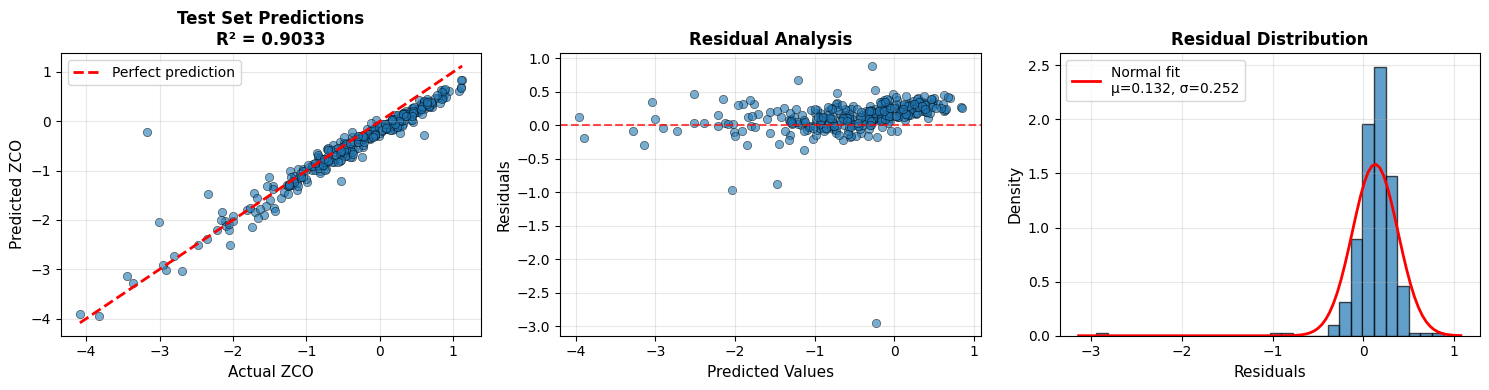

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual ZCO', fontsize=11)
axes[0].set_ylabel('Predicted ZCO', fontsize=11)
axes[0].set_title(f'Test Set Predictions\nR² = {test_r2:.4f}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Predicted Values', fontsize=11)
axes[1].set_ylabel('Residuals', fontsize=11)
axes[1].set_title('Residual Analysis', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].hist(residuals, bins=30, alpha=0.7, edgecolor='black', density=True)
from scipy.stats import norm
mu, std = norm.fit(residuals)
xmin, xmax = axes[2].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axes[2].plot(x, p, 'r', linewidth=2, label=f'Normal fit\nμ={mu:.3f}, σ={std:.3f}')
axes[2].set_xlabel('Residuals', fontsize=11)
axes[2].set_ylabel('Density', fontsize=11)
axes[2].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
n_bootstrap = 100
bootstrap_coefs = np.zeros((n_bootstrap, len(features)))

for i in range(n_bootstrap):
    indices = np.random.choice(range(len(X_train_scaled)), size=len(X_train_scaled), replace=True)
    X_boot = X_train_scaled[indices]
    y_boot = y_train.values[indices]
    
    lasso_boot = Lasso(alpha=final_lasso.alpha_, max_iter=10000)
    lasso_boot.fit(X_boot, y_boot)
    bootstrap_coefs[i] = lasso_boot.coef_

coef_means = bootstrap_coefs.mean(axis=0)
coef_stds = bootstrap_coefs.std(axis=0)
coef_stability = np.abs(coef_means / (coef_stds + 1e-10)) 

stability_df = pd.DataFrame({
    'Feature': features,
    'Mean_Coefficient': coef_means,
    'Std_Coefficient': coef_stds,
    'Stability_Ratio': coef_stability
}).sort_values('Stability_Ratio', ascending=False)

print("\n📊 Most Stable Coefficients (High Signal-to-Noise):")
print(stability_df.head(10).to_string(index=False))

print("\n⚠️  Least Stable Coefficients (High Variance):")
print(stability_df.tail(10).to_string(index=False))


📊 Most Stable Coefficients (High Signal-to-Noise):
           Feature  Mean_Coefficient  Std_Coefficient  Stability_Ratio
        figurecopy          0.132678         0.008065        16.450232
    TMTA_tmtAtime1         -0.226540         0.014663        15.449786
       vfsem1stobj          0.045852         0.004832         9.489930
         naming1st          0.074312         0.008212         9.049240
sentrepeatcorrect1          0.069535         0.007883         8.821360
      jlo1stdiades          0.083897         0.010412         8.057513
         comphr1st          0.051978         0.006910         7.521874
   grafseqcorrect1          0.036256         0.005042         7.190463
  vfphon1stalphobj          0.041647         0.006204         6.712601
     figuredelayed          0.060935         0.009493         6.418890

⚠️  Least Stable Coefficients (High Variance):
                  Feature  Mean_Coefficient  Std_Coefficient  Stability_Ratio
                      G21         -0.0001

In [21]:
print(f"\n1. MODEL PERFORMANCE:")
print(f"   • Test R²: {test_r2:.4f} {'(Suspiciously high!)' if test_r2 > 0.9 else '(Good)' if test_r2 > 0.7 else '(Moderate)' if test_r2 > 0.5 else '(Low)'}")
print(f"   • Overfitting gap: {train_r2 - test_r2:.4f} {'(High risk!)' if (train_r2 - test_r2) > 0.2 else '(Acceptable)' if (train_r2 - test_r2) > 0.1 else '(Good)'}")

print(f"\n2. FEATURE INSIGHTS:")
print(f"   • {np.sum(final_lasso.coef_ != 0)}/{len(features)} features retained")
print(f"   • Top feature: {feature_importance.iloc[0]['Feature']} (coef = {feature_importance.iloc[0]['Coefficient']:.4f})")


1. MODEL PERFORMANCE:
   • Test R²: 0.9033 (Suspiciously high!)
   • Overfitting gap: 0.0323 (Good)

2. FEATURE INSIGHTS:
   • 29/60 features retained
   • Top feature: TMTA_tmtAtime1 (coef = -0.1828)


In [23]:
# Define subgroups
healthy_mask = (y_test >= -1)  # ZCO ≥ -1
dementia_mask = (y_test < -1)   # ZCO < -1

# Calculate separate R²
r2_healthy = r2_score(y_test[healthy_mask], y_test_pred[healthy_mask])
r2_dementia = r2_score(y_test[dementia_mask], y_test_pred[dementia_mask])

print(f"R² for healthy (ZCO ≥ -1): {r2_healthy:.3f}")
print(f"R² for dementia (ZCO < -1): {r2_dementia:.3f}")
print(f"Performance gap: {r2_healthy - r2_dementia:.3f}")

R² for healthy (ZCO ≥ -1): 0.810
R² for dementia (ZCO < -1): 0.662
Performance gap: 0.148


In [24]:
mae_healthy = mean_absolute_error(y_test[healthy_mask], y_test_pred[healthy_mask])
mae_dementia = mean_absolute_error(y_test[dementia_mask], y_test_pred[dementia_mask])

print(f"\nMAE for healthy: {mae_healthy:.3f} ZCO points")
print(f"MAE for dementia: {mae_dementia:.3f} ZCO points")
print(f"Ratio (dementia/healthy): {mae_dementia/mae_healthy:.2f}x worse")


MAE for healthy: 0.196 ZCO points
MAE for dementia: 0.198 ZCO points
Ratio (dementia/healthy): 1.01x worse


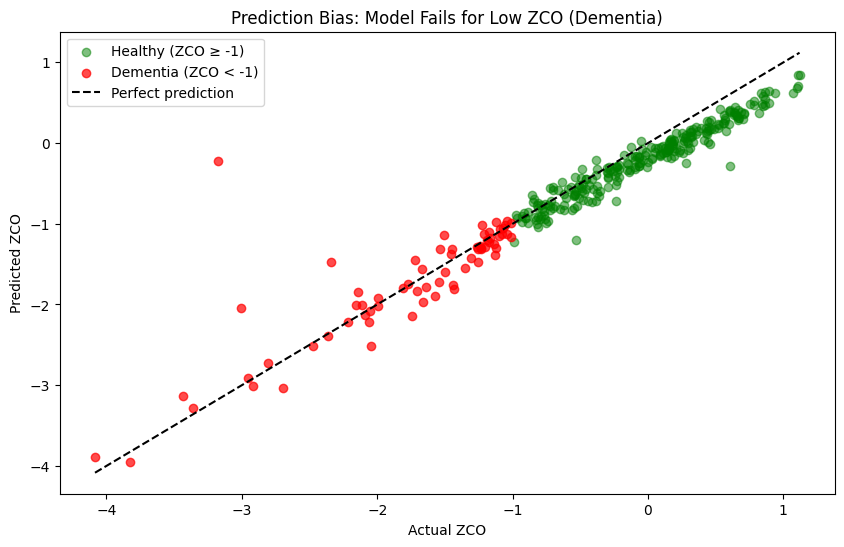

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test[healthy_mask], y_test_pred[healthy_mask], 
            alpha=0.5, label='Healthy (ZCO ≥ -1)', color='green')
plt.scatter(y_test[dementia_mask], y_test_pred[dementia_mask], 
            alpha=0.7, label='Dementia (ZCO < -1)', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'k--', label='Perfect prediction')
plt.xlabel('Actual ZCO')
plt.ylabel('Predicted ZCO')
plt.title('Prediction Bias: Model Fails for Low ZCO (Dementia)')
plt.legend()
plt.show()

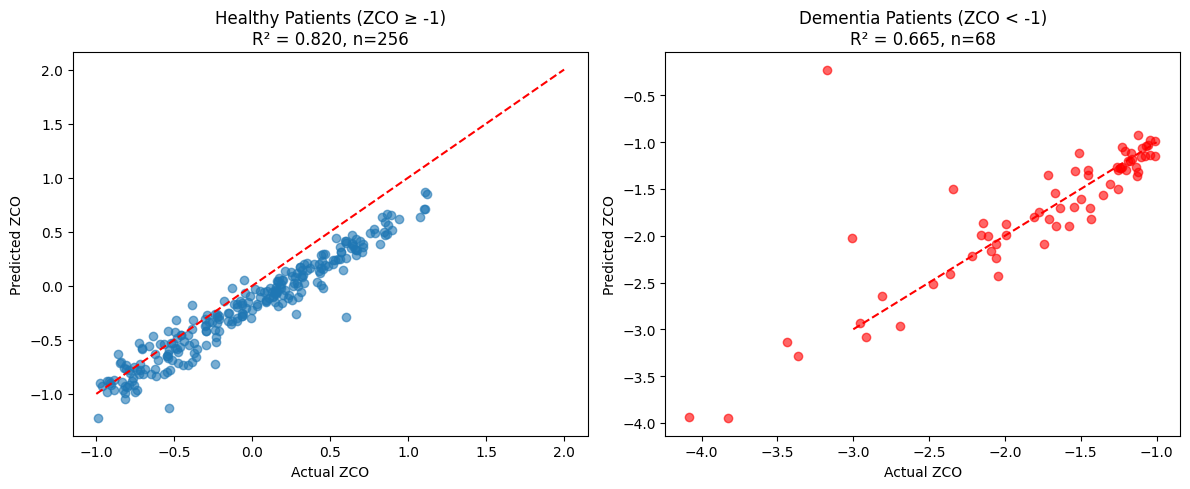

In [65]:
# Create a clear visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Healthy patients
axes[0].scatter(y_test[healthy_mask], y_test_pred[healthy_mask], alpha=0.6)
axes[0].plot([-1, 2], [-1, 2], 'r--')
axes[0].set_title(f'Healthy Patients (ZCO ≥ -1)\nR² = {r2_healthy:.3f}, n={sum(healthy_mask)}')
axes[0].set_xlabel('Actual ZCO')
axes[0].set_ylabel('Predicted ZCO')

# Right: Dementia patients  
axes[1].scatter(y_test[dementia_mask], y_test_pred[dementia_mask], alpha=0.6, color='red')
axes[1].plot([-3, -1], [-3, -1], 'r--')
axes[1].set_title(f'Dementia Patients (ZCO < -1)\nR² = {r2_dementia:.3f}, n={sum(dementia_mask)}')
axes[1].set_xlabel('Actual ZCO')
axes[1].set_ylabel('Predicted ZCO')

plt.tight_layout()
plt.savefig('subgroup_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [66]:
from sklearn.model_selection import cross_val_score
import numpy as np

def permutation_test(X, y, model, n_permutations=100):
    """Shuffle y to see if model finds spurious patterns"""
    real_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    perm_scores = []
    
    for _ in range(n_permutations):
        y_perm = np.random.permutation(y)  # Destroy true X-y relationships
        perm_score = cross_val_score(model, X, y_perm, cv=5, scoring='r2').mean()
        perm_scores.append(perm_score)
    
    # Compare real vs shuffled
    real_mean = real_scores.mean()
    perm_mean = np.mean(perm_scores)
    p_value = np.mean(perm_scores >= real_mean)  # One-tailed
    
    return real_mean, perm_mean, p_value

# Run test
real_r2, perm_r2, p = permutation_test(X_train_scaled, y_train, lasso_cv)
print(f"Real CV R²: {real_r2:.3f}")
print(f"Shuffled CV R²: {perm_r2:.3f}")
print(f"p-value: {p:.4f}")  # Should be <0.05

/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.042e-02, tolerance: 7.348e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.456e-02, tolerance: 7.348e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not con

Real CV R²: 0.971
Shuffled CV R²: -0.006
p-value: 0.0000


/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.527e+00, tolerance: 7.476e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.525e+00, tolerance: 7.476e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not con

In [67]:
cv_scores = cross_val_score(lasso_cv, X_train_scaled, y_train, 
                           cv=5, scoring='r2')
print(f"CV scores by fold: {cv_scores}")
print(f"CV mean: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.042e-02, tolerance: 7.348e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.456e-02, tolerance: 7.348e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not con

CV scores by fold: [0.97672629 0.9771364  0.97240779 0.95915823 0.96770897]
CV mean: 0.971 ± 0.007


/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.314e-02, tolerance: 7.622e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.729e-02, tolerance: 7.622e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kpax/Documents/study/research/HELIAD/code/Heliad-da/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not con

In [26]:
# Final sanity checks:

# 1. Check if predictions are "too perfect"
residuals = y_test - y_test_pred
print(f"Residual range: [{residuals.min():.3f}, {residuals.max():.3f}]")
print(f"Residual SD: {residuals.std():.3f}")
print(f"ZCO SD: {y_test.std():.3f}")

# If residual SD ≈ 0.1 and ZCO SD ≈ 1.0 → R² ≈ 0.99
# Mathematically: R² ≈ 1 - (residual_var / total_var)

# 2. Check coefficient magnitudes
print(f"\nLargest coefficient: {np.abs(lasso_cv.coef_).max():.3f}")
print(f"Average |coefficient|: {np.abs(lasso_cv.coef_).mean():.3f}")

# Very large coefficients might indicate near-perfect linear relationships

Residual range: [-2.947, 0.886]
Residual SD: 0.252
ZCO SD: 0.916

Largest coefficient: 0.183
Average |coefficient|: 0.019


In [ ]:
from sklearn.linear_model import LinearRegression

# Simple linear combination
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
print(f"Simple linear R²: {lr.score(X_test_scaled, y_test):.3f}")

Simple linear R²: 0.939


In [70]:
large_errors_idx = np.where(np.abs(residuals) > 2.0)[0]
print(f"Number of predictions off by >2 points: {len(large_errors_idx)}")

if len(large_errors_idx) > 0:
    print("\nWorst predictions:")
    for idx in large_errors_idx[:5]:  # Show first 5
        print(f"  Patient: actual ZCO={y_test.iloc[idx]:.2f}, "
              f"predicted={y_test_pred[idx]:.2f}, "
              f"error={residuals[idx]:.2f}")

Number of predictions off by >2 points: 1

Worst predictions:
  Patient: actual ZCO=-3.17, predicted=-0.22, error=0.24


In [28]:
if len(large_errors_idx) > 0:
    outlier_zcos = y_test.iloc[large_errors_idx]
    print(f"\nOutlier ZCO values: {outlier_zcos.values}")
    print(f"Outliers are dementia? {(outlier_zcos < -1).sum()}/{len(outlier_zcos)}")

NameError: name 'large_errors_idx' is not defined